# Domain Features Classification, Full Audio File

#### Use Domain Features to Classify Audio Samples

In [1]:
#import packages
#general 
import pandas as pd
import numpy as np
import itertools
from collections import Counter

#visualization packages
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import Audio
from IPython.display import display

#file reading
import glob
import os

#audio signal processing
from scipy import fftpack
from scipy import signal
from scipy.io import wavfile
from scipy.signal import find_peaks

#modeling
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold

# DataSet

#### Sound Classes (20 X 30s audio samples for each)
* [Fire Alarm](https://www.youtube.com/watch?v=nIfIAgkB-MI)
* Song
    - (5) Folsom Prison Blues - Johnny Cash
    - (5) Cocoa Butter Kisses - Chance the Rapper
    - (5) 3005 - Childish Gambino
    - (5) Alive with the Glory of Love - Say Anything
* Microwave
* Blender
* Vacuum
* Silence


## Read and Collect Audio File Info

In [2]:
#create df to store file labels and paths 
audioInfo_DF = pd.DataFrame(columns = ['label', 'name', 'path'])

#cycle through each folder and wav file
for file in glob.glob('data/*/*.wav'):
    #create DFrow dictionary to hold row information that will be appended
    dfRow = {}
    pathList = file.split('\\')
    dfRow['label'] = pathList[-2]
    dfRow['name'] = pathList[-1]
    dfRow['path'] = file
    #add file label, name, and path to DF
    audioInfo_DF=audioInfo_DF.append(dfRow, ignore_index=True)

audioInfo_DF.head()

,label,name,path
0,alarm,alarm102019_10_06_10_03_49.wav,data\alarm\alarm102019_10_06_10_03_49.wav
1,alarm,alarm12019_10_06_09_54_08.wav,data\alarm\alarm12019_10_06_09_54_08.wav
2,alarm,alarm22019_10_06_09_55_03.wav,data\alarm\alarm22019_10_06_09_55_03.wav
3,alarm,alarm312019_10_07_16_35_07.wav,data\alarm\alarm312019_10_07_16_35_07.wav
4,alarm,alarm32019_10_06_09_55_56.wav,data\alarm\alarm32019_10_06_09_55_56.wav


# Test Median Filtering rates

#### I'll be applying some measure of median filtering to the audio file data just to smooth out the noise. First, I'll check the filter sizes against the Audio player to ensure not too much data is lost

#### Top Player = No Filter
#### Bottom Player = Median Filter

In [3]:
#create an interactive audio player to listen to listen to the files
@interact(idx=(0,len(audioInfo_DF)))
def playAudio(idx):
    rate, amp = wavfile.read(os.path.abspath(audioInfo_DF['path'][idx])) #read in file
    #show amplitude chart
    time = np.arange(0, amp.size/rate, 1/rate)
    plt.plot(time[10000:10100], amp[10000:10100])
    plt.title('Audio Recording: %d'%idx)
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')
    plt.show()
    #Display audio player
    display(Audio(amp, rate=rate))
    
    # apply filter and create another player
    amp = signal.medfilt(amp,11)
    #show amplitude chart
    time = np.arange(0, amp.size/rate, 1/rate)
    plt.plot(time[10000:10100], amp[10000:10100])
    plt.title('Audio Recording: %d'%idx)
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')
    plt.show()
    #Display audio player
    display(Audio(amp, rate=rate))

interactive(children=(IntSlider(value=65, description='idx', max=130), Output()), _dom_classes=('widget-intera…

# Create a Dataset

#### Read each of the wav files, divide them into 3s overlapping windows, and reduce them into a feature set

In [4]:
def loadWave(idx):
    #get read rate and time series amplitude from wav file
    rate, amp = wavfile.read(audioInfo_DF['path'][idx])
    amp = amp.astype(float) # convert to float
    return rate, amp

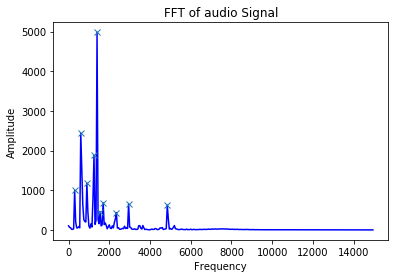

([1400, 600, 1250, 900, 300, 2950, 4850, 1700, 2350, 1550],
 [4981.32199279412,
  2440.849757231213,
  1887.2578239228008,
  1181.356333215875,
  996.8501990978391,
  657.9446538381861,
  626.6778104626399,
  682.5694803711599,
  436.81508529161937,
  456.82680015219955],
 10,
 1475.0)

In [5]:
#create formula for extracting frequency peaks
def calcFilterSize(rate):
    '''
    Calculates integer filter size to use based on audios sampling rate
    return: odd integer
    '''
    SizeToRateRatio = 11/44100
    filterSize = int(rate * SizeToRateRatio)
    #ensure filter Size is odd
    if filterSize%2 != 1:
        filterSize += 1
    return filterSize

def getFFTPeaks(rate, amp, n=5, show=False):
    '''
    input: audio sampling rate, (float)
            amplitude readings, (np.array)
    output: 
            top n frequency peak frequencies, (np.array)
            top n frequency peak amplitudes, (np.array)
    '''
    #normalize amplitudes
    amp = amp.astype(float) # convert to float
    amp = (amp - amp.mean())/ np.max(np.abs(amp)) # normalize
    
    #change signal to frequency domain
    freqAmp = abs(fftpack.fft(amp))
    freqList = fftpack.fftfreq(len(amp)) * rate
    
    #slice arrays to remove frequency reflection
    freqAmp = freqAmp[range(len(freqAmp)//2)]
    freqList = freqList[range(len(freqList)//2)]
    
    #remove frequencies above 15000
    freqMask = freqList < 15000
    freqAmp = freqAmp[freqMask]
    freqList = freqList[freqMask]
    
#     #apply median filtering to FFT to isolate peaks
    filterSize = calcFilterSize(rate)
#     freqAmp = signal.medfilt(freqAmp,filterSize)
    
    #downsample the frequency list to 1 point for each 10 hertz
    downSample = int(1/(freqList[1]-freqList[0])) * 50
    freqAmp = np.array([freqAmp[i*downSample : (i*downSample + downSample)].max() for i in range(len(freqAmp)//downSample)])
    freqList = np.array((range(len(freqList)//downSample))) * 50
    
    
    
    #get peaks
    #restrict distance between them and the required height
    peaks, prop = find_peaks(freqAmp, height=np.percentile(freqAmp,95), prominence=0)
    #get top peaks by height
    peakProminenceOrder = np.argsort(prop['prominences'])[::-1]
    topN = peakProminenceOrder[:n]
    
    #get total number of peaks as a feature
    peakCount = len(peaks)
    medPeak = np.median(freqList[peaks])
    
    if show:
        plt.plot(freqList, freqAmp, linestyle='-', color='blue')
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.plot(freqList[peaks[topN]], freqAmp[peaks[topN]], "x")
        plt.title("FFT of audio Signal")
        plt.show()
    
    #right pad frequencies and amplitudes to ensure n are returned
    zeroPad = [0]*(n-len(topN))
    
    #return top n frequencies and their amplitudes
    return (list(freqList[peaks[topN]]) + zeroPad, list(freqAmp[peaks[topN]]) + zeroPad, peakCount, medPeak)

#test peaks function
sample_i = 11
rate, amp = loadWave(sample_i)
#get clip
amp = amp[1000:(1000 + rate*3)]
getFFTPeaks(rate, amp, n=10, show=True)

In [6]:
def getDistFeatures(rate, amp):
    '''
    input: sampling rate (float)
            amplitudes (np.array)
    output:
             distributional features of the audio amplitudes
    '''
    distFeatures = []
    distFeatures.append(np.median(abs(amp))) #medianAmp
    distFeatures.append(np.percentile(abs(amp), 95)) #maxAmp
    distFeatures.append(np.std(amp))
    return distFeatures

In [7]:
#create dataset using above functions

X  = []  #holds dataset features
y = [] #holds dataet labels
#read through each of the files in the audioInfo_DF. 
#Create a feature set from each amplitudes
for idx in range(len(audioInfo_DF)):
    rate, amp = loadWave(idx) #read file
    features = [] #holds features caculated from each audio clip
    #add frequency peaks
    peakFreqs, peakAmps, peakCount, medPeak = getFFTPeaks(rate, amp, n=10) #send amp to FFT peak calculation
    #add FFT features to list
    features = features + peakFreqs + peakAmps
    features.append(peakCount)
    features.append(medPeak)
    #add distributional features
    features += getDistFeatures(rate, amp)
    #append feature set to X
    X.append(np.array(features).astype(float))
    #add label to y list
    y.append(audioInfo_DF['label'][idx])

#convert to numpy and print array sizes
X = np.array(X)
y = np.array(y)
print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (130, 25)
y shape:  (130,)


## Check Class Balance

#### The class sample counts are still relatively balanced. No need to resample

In [8]:
# chart class distribution of audio files
catCounts = Counter()
catCounts.update(y)
print(catCounts.items())
sCatCounter = sorted(catCounts.items(), key = lambda x: x[1])
print('File counts for each class')
for cat, row in sCatCounter:
    print('Category: %s \t Count: %s'%(cat,str(row)))

dict_items([('alarm', 22), ('blender', 21), ('microwave', 20), ('silent', 21), ('songs', 26), ('vacuum', 20)])
File counts for each class
Category: microwave 	 Count: 20
Category: vacuum 	 Count: 20
Category: blender 	 Count: 21
Category: silent 	 Count: 21
Category: alarm 	 Count: 22
Category: songs 	 Count: 26


# Format Dataset and Labels

In [9]:
#normalize feature set
Xnorm = normalize(X)
#encode labels
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.33, random_state=42)

# Train Classification Models

In [10]:
#get average accuracy of model using kfold split
def getAccuracy(model, X, y, show=False):
    cv = KFold(n_splits=10)
    scores = []
    
    for train_index, test_index in cv.split(X, y):
        if(show):
            print("Train Index: ", train_index)
            print("Test Index: ", test_index)
        X_train, X_val, y_train, y_val = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_val, y_val))
    acc = np.mean(scores)
    if show:
        print("Mean accuracy:" + str(acc))
    return acc

In [11]:
#SVM hyperparameter selection

#set hyperparameter lists
cValues = [1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8]
kernels = ['linear', 'poly', 'rbf']
bestSvmModel = None
bestAcc = 0

#get model accuracy for each combination of hyperparameters
for parPair in itertools.product(cValues, kernels):
    model = SVC(C=parPair[0], kernel=parPair[1], gamma='auto')
    acc = getAccuracy(model, X_train, y_train)
    # training info printout
    print("%-20s \t\t acc: %-10s"%(str(parPair), str(round(acc,4)*100)+'%'))
    if acc > bestAcc:
        bestSvmModel = model
        bestAcc = acc

#print best model hyperparameters
print('\n*** Best Model ***')
print("Accuracy: " + str(round(bestAcc,4)*100)+'%')
print("Parameters: " + str(bestSvmModel.get_params))

(0.0001, 'linear')   		 acc: 20.0%     
(0.0001, 'poly')     		 acc: 22.5%     
(0.0001, 'rbf')      		 acc: 21.25%    
(0.01, 'linear')     		 acc: 20.0%     
(0.01, 'poly')       		 acc: 22.5%     
(0.01, 'rbf')        		 acc: 21.25%    
(1, 'linear')        		 acc: 56.38999999999999%
(1, 'poly')          		 acc: 22.5%     
(1, 'rbf')           		 acc: 21.25%    
(100.0, 'linear')    		 acc: 94.31%    
(100.0, 'poly')      		 acc: 22.5%     
(100.0, 'rbf')       		 acc: 89.58%    
(10000.0, 'linear')  		 acc: 95.42%    
(10000.0, 'poly')    		 acc: 69.17%    
(10000.0, 'rbf')     		 acc: 95.42%    
(1000000.0, 'linear') 		 acc: 95.42%    
(1000000.0, 'poly')  		 acc: 91.94%    
(1000000.0, 'rbf')   		 acc: 95.42%    
(100000000.0, 'linear') 		 acc: 95.42%    
(100000000.0, 'poly') 		 acc: 91.94%    
(100000000.0, 'rbf') 		 acc: 95.42%    

*** Best Model ***
Accuracy: 95.42%
Parameters: <bound method BaseEstimator.get_params of SVC(C=10000.0, cache_size=200, class_weight=None, coef0=

In [12]:
# Random Forest hyperparameter selection
#set hyperparameter lists
n = [500]
c = ['gini', 'entropy'] 
maxD = [None,1,5,10,20]
bestRFModel = None
bestAcc = 0

#get model accuracy for each combination of hyperparameters
for parPair in itertools.product(n,c, maxD):
    model = RandomForestClassifier(n_estimators=parPair[0], criterion=parPair[1], max_depth=parPair[2])
    acc = getAccuracy(model, X_train, y_train)
    # training info printout
    print("%-20s \t\t acc: %-10s"%(str(parPair), str(round(acc,4)*100)+'%'))
    if acc > bestAcc:
        bestRFModel = model
        bestAcc = acc

#print best model hyperparameters
print('\n*** Best Model ***')
print("Accuracy: " + str(round(bestAcc,4)*100)+'%')
print("Parameters: " + str(bestRFModel.get_params))

(500, 'gini', None)  		 acc: 95.42%    
(500, 'gini', 1)     		 acc: 71.25%    
(500, 'gini', 5)     		 acc: 94.31%    
(500, 'gini', 10)    		 acc: 95.42%    
(500, 'gini', 20)    		 acc: 95.42%    
(500, 'entropy', None) 		 acc: 95.42%    
(500, 'entropy', 1)  		 acc: 59.03%    
(500, 'entropy', 5)  		 acc: 95.42%    
(500, 'entropy', 10) 		 acc: 95.42%    
(500, 'entropy', 20) 		 acc: 95.42%    

*** Best Model ***
Accuracy: 95.42%
Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>


# Use "unseen" Data for Final Model Test

In [13]:
favModel = bestRFModel

Confusion matrix, without normalization
Normalized confusion matrix


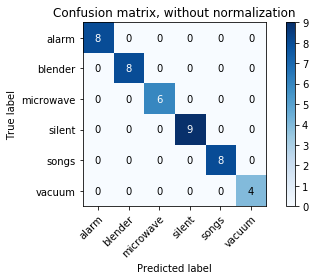

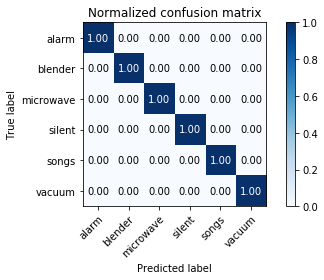

In [14]:
#the code below was taken from an SKLearn tutorial
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#get predicted classes for test dataset
y_pred = favModel.predict(X_test)
class_names = sorted(set(y))


#use sklearn function to print confusion matrixes
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [15]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,alarm,blender,microwave,silent,songs,vacuum,All
True,,,,,,,
alarm,8,0,0,0,0,0,8
blender,0,8,0,0,0,0,8
microwave,0,0,6,0,0,0,6
silent,0,0,0,9,0,0,9
songs,0,0,0,0,8,0,8
vacuum,0,0,0,0,0,4,4
All,8,8,6,9,8,4,43
